In [64]:
%matplotlib inline

from numpy import *
import innvestigate
import sys

from keras.models import Model
from keras.layers import Input
from keras.layers.merge import Multiply
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution1D, AveragePooling1D

In [65]:
def PREPROCESS(lines):
    data_n = len(lines) - 1
    SEQ = zeros((data_n, 34, 4), dtype=int)
    CA = zeros((data_n, 1), dtype=int)
    
    for l in range(1, data_n+1):
        data = lines[l].split()
        seq = data[1]
        for i in range(34):
            if seq[i] in "Aa":
                SEQ[l-1, i, 0] = 1
            elif seq[i] in "Cc":
                SEQ[l-1, i, 1] = 1
            elif seq[i] in "Gg":
                SEQ[l-1, i, 2] = 1
            elif seq[i] in "Tt":
                SEQ[l-1, i, 3] = 1
        CA[l-1,0] = int(data[2])

    return SEQ, CA

In [67]:
print("Usage: python DeepCpf1.py input.txt output.txt")
print("input.txt must include 3 columns with single header row")
print("\t1st column: sequence index")
print("\t2nd column: 34bp target sequence")
print("\t3rd column: binary chromain information of the target sequence\n")

print("DeepCpf1 currently requires python=2.7.12, theano=0.7.0, keras=0.3.3")
print("DeepCpf1 available on GitHub requires pre-obtained binary chromatin information (DNase-seq narraow peak data from ENCODE)")
print("DeepCpf1 web tool, available at http://data.snu.ac.kr/DeepCpf1, provides entire pipeline including binary chromatin accessibility for 125 cell lines\n")

if len(sys.argv) < 3:
    sys.exit()

print("Building models")
Seq_deepCpf1_Input_SEQ = Input(shape=(34,4))
Seq_deepCpf1_C1 = Convolution1D(80, 5, activation='relu')(Seq_deepCpf1_Input_SEQ)
Seq_deepCpf1_P1 = AveragePooling1D(2)(Seq_deepCpf1_C1)
Seq_deepCpf1_F = Flatten()(Seq_deepCpf1_P1)
Seq_deepCpf1_DO1= Dropout(0.3)(Seq_deepCpf1_F)
Seq_deepCpf1_D1 = Dense(80, activation='relu')(Seq_deepCpf1_DO1)
Seq_deepCpf1_DO2= Dropout(0.3)(Seq_deepCpf1_D1)
Seq_deepCpf1_D2 = Dense(40, activation='relu')(Seq_deepCpf1_DO2)
Seq_deepCpf1_DO3= Dropout(0.3)(Seq_deepCpf1_D2)
Seq_deepCpf1_D3 = Dense(40, activation='relu')(Seq_deepCpf1_DO3)
Seq_deepCpf1_DO4= Dropout(0.3)(Seq_deepCpf1_D3)
Seq_deepCpf1_Output = Dense(1, activation='linear')(Seq_deepCpf1_DO4)
Seq_deepCpf1 = Model(inputs=[Seq_deepCpf1_Input_SEQ], outputs=[Seq_deepCpf1_Output])

DeepCpf1_Input_SEQ = Input(shape=(34,4))
DeepCpf1_C1 = Convolution1D(80, 5, activation='relu')(DeepCpf1_Input_SEQ)
DeepCpf1_P1 = AveragePooling1D(2)(DeepCpf1_C1)
DeepCpf1_F = Flatten()(DeepCpf1_P1)
DeepCpf1_DO1= Dropout(0.3)(DeepCpf1_F)
DeepCpf1_D1 = Dense(80, activation='relu')(DeepCpf1_DO1)
DeepCpf1_DO2= Dropout(0.3)(DeepCpf1_D1)
DeepCpf1_D2 = Dense(40, activation='relu')(DeepCpf1_DO2)
DeepCpf1_DO3= Dropout(0.3)(DeepCpf1_D2)
DeepCpf1_D3_SEQ = Dense(40, activation='relu')(DeepCpf1_DO3)

DeepCpf1_Input_CA = Input(shape=(1,))
DeepCpf1_D3_CA = Dense(40, activation='relu')(DeepCpf1_Input_CA)
DeepCpf1_M = Multiply()([DeepCpf1_D3_SEQ, DeepCpf1_D3_CA])

DeepCpf1_DO4= Dropout(0.3)(DeepCpf1_M)
DeepCpf1_Output = Dense(1, activation='linear')(DeepCpf1_DO4)
DeepCpf1 = Model(inputs=[DeepCpf1_Input_SEQ, DeepCpf1_Input_CA], outputs=[DeepCpf1_Output])

print("Loading weights for the models")
Seq_deepCpf1.load_weights('weights/Seq_deepCpf1_weights.h5')
DeepCpf1.load_weights('weights/DeepCpf1_weights.h5')

print("Loading test data")
FILE = open("input_example.txt", "r")
data = FILE.readlines()
SEQ, CA = PREPROCESS(data)
FILE.close()

print("Predicting on test data")
Seq_deepCpf1_SCORE = Seq_deepCpf1.predict([SEQ], batch_size=50, verbose=0)
DeepCpf1_SCORE = DeepCpf1.predict([SEQ, CA], batch_size=50, verbose=0) * 3

print("Saving to " + sys.argv[2])
OUTPUT = open(sys.argv[2], "w")
for l in range(len(data)):
    if l == 0:
        OUTPUT.write(data[l].strip())
        OUTPUT.write("\tSeq-deepCpf1 Score\tDeepCpf1 Score\n")
    else:
        OUTPUT.write(data[l].strip())
        OUTPUT.write("\t%f\t%f\n" % (Seq_deepCpf1_SCORE[l-1], DeepCpf1_SCORE[l-1]))
OUTPUT.close()

Usage: python DeepCpf1.py input.txt output.txt
input.txt must include 3 columns with single header row
	1st column: sequence index
	2nd column: 34bp target sequence
	3rd column: binary chromain information of the target sequence

DeepCpf1 currently requires python=2.7.12, theano=0.7.0, keras=0.3.3
DeepCpf1 available on GitHub requires pre-obtained binary chromatin information (DNase-seq narraow peak data from ENCODE)
DeepCpf1 web tool, available at http://data.snu.ac.kr/DeepCpf1, provides entire pipeline including binary chromatin accessibility for 125 cell lines

Building models


Loading weights for the models


Loading test data
Predicting on test data


Saving to C:\Users\Sebastian\AppData\Roaming\jupyter\runtime\kernel-030c3091-9108-4148-a9da-3bcc640e14c5.json


Analyzing NN


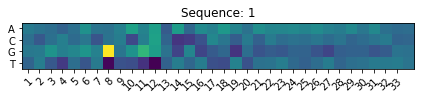

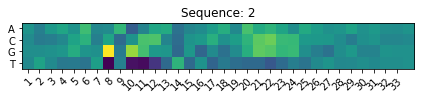

In [68]:
#Analyze

print("Analyzing NN")
analyzer = innvestigate.create_analyzer("gradient", Seq_deepCpf1)
analysis = analyzer.analyze(SEQ)

grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]

import numpy as np
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

positions = range(1,34)
bases = ["A", "C", "G", "T"]

for i in range(0,len(grid)):
    harvest = transpose(grid[i])
    
    fig, ax = plt.subplots()
    im = ax.imshow(harvest)
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(positions)))
    ax.set_yticks(np.arange(len(bases)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(positions)
    ax.set_yticklabels(bases)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    #for i in range(len(bases)):
    #    for j in range(len(positions)):
    #        text = ax.text(j, i, harvest[i, j],
    #                       ha="center", va="center", color="w")
    
    ax.set_title("Sequence: "+str(i+1))
    fig.tight_layout()
    plt.show()